# Sovereign debt sustainability and CDS returns

This notebook serves as an illustration of the points discussed in the post [“Sovereign debt sustainability and CDS returns”](https://research.macrosynergy.com/sovereign-debt-sustainability-and-cds-returns/) available on the Macrosynergy website.

Sovereign credit default swaps allow investors to take long or short positions in respect to government finance risks. Selling protection through CDS contracts is akin to writing a put option with the sovereign default marking a strike. This characteristic, alongside the tenuous liquidity in this OTC market explains the negative skew and heavy fat tails of generic CDS (short protection or long credit) returns. Since default risk depends critically on sovereign debt dynamics, we examine the relationship between a point-in-time mechanical metric of extrapolated general government debt ratios (based on unchanged market conditions) and CDS returns. There is strong evidence of a negative relation between increases in predicted debt ratios and concurrent returns. There is also evidence of a negative predictive relation between debt ratio changes and subsequent CDS returns. Trading deteriorating government financial sustainability seems to produce modest but consistent alpha.


This notebook provides the essential code required to replicate the analysis discussed in the post.

The notebook covers the three main parts:

- Get Packages and JPMaQS Data: This section is responsible for installing and importing the necessary Python packages used throughout the analysis.

- Transformations and Checks: In this part, the notebook performs calculations and transformations on the data to derive the relevant signals and targets used for the analysis, including the normalization of feature variables using z-score or building simple linear composite indicators.

- Value Checks: This is the most critical section, where the notebook calculates and implements the trading strategies based on the hypotheses tested in the post. This section involves backtesting simple trading strategies. In particular, the post investigates the hypothesis that deterioration in debt sustainability indicators coincides with negative CDS returns. Another tested hypothesis is that conscientious following of short-term trends in sustainability indicators offers an information advantage and predicts subsequent CDS returns. The third tested hypothesis draws on the characteristic of credit exposure being similar to a short option position with limited liquidity. A common view among traders is that markets underestimate how much the world can change and that tail risk is underpriced.


It is important to note that while the notebook covers a selection of indicators and strategies used for the post’s main findings, users can explore countless other possible indicators and approaches. Users can modify the code to test different hypotheses and strategies based on their research and ideas. Best of luck with your research!

## Get packages and JPMaQS data

This notebook primarily relies on the standard packages available in the Python data science stack. However, there is an additional package, `macrosynergy` that is required for two purposes:

- Downloading JPMaQS data: The `macrosynergy` package facilitates the retrieval of JPMaQS data, which is used in the notebook.

- For the analysis of quantamental data and value propositions: The `macrosynergy` package provides functionality for performing quick analyses of quantamental data and exploring value propositions.

For detailed information and a comprehensive understanding of the `macrosynergy` package and its functionalities, please refer to the [“Introduction to Macrosynergy package”](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php) notebook on the Macrosynergy Quantamental Academy or visit the following link on [Kaggle](https://www.kaggle.com/code/macrosynergy/introduction-to-macrosynergy-package).

In [1]:
# Run only if needed!
"""
%%capture
! pip install macrosynergy --upgrade"""

'\n%%capture\n! pip install macrosynergy --upgrade'

In [2]:
import numpy as np
import pandas as pd
from pandas import Timestamp
import matplotlib.pyplot as plt
import seaborn as sns
import os

import macrosynergy.management as msm
import macrosynergy.panel as msp
import macrosynergy.signal as mss
import macrosynergy.pnl as msn

from macrosynergy.download import JPMaQSDownload

import warnings

warnings.simplefilter("ignore")

The post looks at sovereign CDS markets for the following:  
- developed market countries: CHF/Switzerland (since 2009), DEM/German (since 2005), ESP/Spain (since 2005), FRF/France (since 2006), GBP/UK (since 2007), ITL/Italy (since 2005), JPY/Japan (since 2001), SEK/Sweden (since 2008), USD/U.S. (since 2014).
- emerging market sovereigns: BRL/Brazil (since 2000), CLP/Chile (since 2007), CNY/China (since 2006), COP/Colombia (since 2000), CZK/Czechia (since 2004), HUF/Hungary (since 2000), IDR/Indonesia (since 2004), ILS/Israel (2004), KRW/South Korea (since 2004), MXN/Mexico (since 2000), MYR/Malaysia (since 2003), PEN/Peru (since 2003), PHP/Philippines (since 2005), PLN/Poland (since 2000), RON/Romania (since 2002), THB/Thailand (since 2005), TRY/Turkey (since 2002), ZAR/South Africa (since 2002)


In [3]:
# Bond-specific cross-sections

cids_dmea = [
    "FRF",
    "DEM",
    "ITL",
    "ESP",
]

cids_dmxe = [
    "CHF",
    "GBP",
    "JPY",
    "SEK",
    "USD",
]

cids_dm = cids_dmea + cids_dmxe
cids_g10 = [ "FRF", "DEM", "ITL", "ESP","USD","GBP","SEK"]

cids_latm = [
    "BRL",
    "CLP",
    "COP",
    "MXN",
    "PEN",
]  # Latam sovereigns
cids_emea = [
    "CZK",
    "HUF",
    "ILS",
    "PLN",
    "RON",
    "ZAR",
    "TRY",
]  # EMEA sovereigns
cids_emas = [
   
    "CNY",
    "IDR",
    "KRW",
    "MYR",
    "PHP",
    "THB",
]  # EM Asia sovereigns


cids_em = cids_emea + cids_latm + cids_emas
cids = cids_dm + cids_em

The description of each JPMaQS category is available under [Macro quantamental academy](https://academy.macrosynergy.com/quantamental-indicators/), or [JPMorgan Markets](https://markets.jpmorgan.com/#jpmaqs) (password protected). For tickers used in this notebook see [Government debt sustainability](https://academy.macrosynergy.com/academy/Themes/Macroeconomic%20balance%20sheets/_build/html/notebooks/Government%20debt%20sustainability.php), [Sovereign CDS returns](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Sovereign%20CDS%20returns.php), [Equity index future returns](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Equity%20index%20future%20returns.php), and [Government bond returns](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Government%20bond%20returns.php)

In [4]:
# Category tickers

# Debt sustainability indicators

main = ["XNGGPBGDPRATIO_NSA", "GGDGDPRATIOX10_NSA"]

# Target returns

rets = [
    "CDS05YXR_NSA",
    "CDS05YXR_VT10",
]  # Generic government bond excess returns

# Tickers

xcats = main + rets
xtix = ["USD_EQXR_NSA", "USD_GB05YR_NSA"]  # USD equity futures excess returns and government bond returns


tickers = [cid + "_" + xcat for cid in cids for xcat in xcats] + xtix
print(f"Maximum number of tickers is {len(tickers)}")

Maximum number of tickers is 110


In [5]:
# Download series from J.P. Morgan DataQuery by tickers

client_id: str = os.getenv("DQ_CLIENT_ID")
client_secret: str = os.getenv("DQ_CLIENT_SECRET")

with JPMaQSDownload(client_id=client_id, client_secret=client_secret) as dq:
    df = dq.download(
        tickers=tickers,
        start_date="2000-01-01",
        suppress_warning=True,
        metrics=[
            "value",
        ],
        show_progress=True,
    )

Timestamp UTC:  2024-03-21 15:05:37
Connection successful!


Requesting data: 100%|██████████| 6/6 [00:01<00:00,  4.94it/s]


Some expressions are missing from the downloaded data. Check logger output for complete list.
2 out of 110 expressions are missing. To download the catalogue of all available expressions and filter the unavailable expressions, set `get_catalogue=True` in the call to `JPMaQSDownload.download()`.
Some dates are missing from the downloaded data. 
2 out of 6321 dates are missing.


The JPMaQS indicators we consider are downloaded using the J.P. Morgan Dataquery API interface within the `macrosynergy` package. This is done by specifying ticker strings, formed by appending an indicator category code <category> to a currency area code <cross_section>. These constitute the main part of a full quantamental indicator ticker, taking the form `DB(JPMAQS,<cross_section>_<category>,<info>)`, where <info> denotes the time series of information for the given cross-section and category. The following types of information are available:

`value` giving the latest available values for the indicator
`eop_lag` referring to days elapsed since the end of the observation period
`mop_lag` referring to the number of days elapsed since the mean observation period
`grade` denoting a grade of the observation, giving a metric of real-time information quality.

After instantiating the `JPMaQSDownload` class within the `macrosynergy.download` module, one can use the `download(tickers,start_date,metrics)` method to easily download the necessary data, where `tickers` is an array of ticker strings, `start_date` is the first collection date to be considered and `metrics` is an array comprising the times series information to be downloaded. For more information see [here](https://github.com/macrosynergy/macrosynergy/blob/develop/README.md)

In [6]:
dfx = df.copy().sort_values(["cid", "xcat", "real_date"])
dfx.info()
print(dfx['xcat'].unique())

<class 'pandas.core.frame.DataFrame'>
Index: 579148 entries, 0 to 579139
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   real_date  579148 non-null  datetime64[ns]
 1   cid        579148 non-null  object        
 2   xcat       579148 non-null  object        
 3   value      579148 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 22.1+ MB
['CDS05YXR_NSA' 'CDS05YXR_VT10' 'GGDGDPRATIOX10_NSA' 'XNGGPBGDPRATIO_NSA'
 'EQXR_NSA' 'GB05YR_NSA']


### Availability

It is important to assess data availability before conducting any analysis. It allows for the identification of any potential gaps or limitations in the dataset, which can impact the validity and reliability of analysis and ensure that a sufficient number of observations for each selected category and cross-section is available, as well as determining the appropriate time periods for analysis. 

In [7]:
msm.missing_in_df(df, xcats=xcats, cids=cids)

Missing xcats across df:  []
Missing cids for CDS05YXR_NSA:  []
Missing cids for CDS05YXR_VT10:  []
Missing cids for GGDGDPRATIOX10_NSA:  ['PHP']
Missing cids for XNGGPBGDPRATIO_NSA:  ['PHP']


[check_availability()](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#view-available-data-history-with-check-availability) functions list visualizes start years and the number of missing values at or before the end date of all selected cross-sections and across a list of categories. It also displays unavailable indicators as gray fields and color codes for the starting year of each series, with darker colors indicating more recent starting years. 

The function [missing_in_df()](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#detect-missing-categories-or-cross-sections-with-missing-in-df) is complimentary to check_availability and simply displays (1) categories that are missing across all expected cross-sections for a given category name list, and (2) cross-sections that are missing within a category.

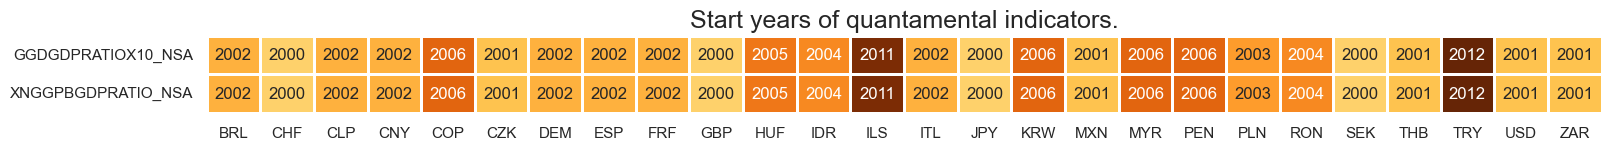

In [8]:
msm.check_availability(df, xcats=main, cids=cids, missing_recent=False)

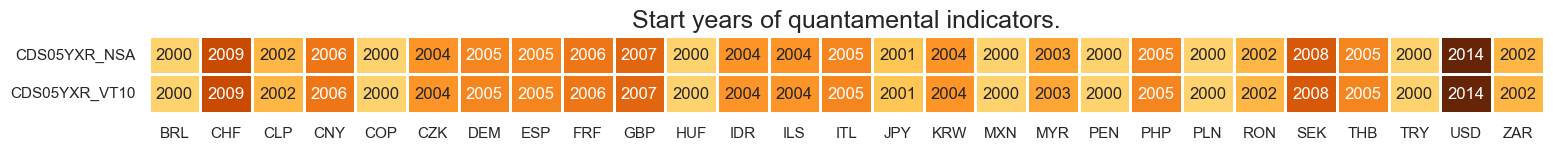

In [9]:
msm.check_availability(df, xcats=rets, cids=cids, missing_recent=False)

## Transformations and checks

### Features

#### Sustainability trends

Here, with the help of [`view_timelines()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#visualize-panel-time-series-with-view-timelines) from the `macrosynergy` package we plot the extrapolated general government ration in 10 years, % of GDP. It indicates where, all other things equal, the debt-to-GDP ratio of a government would move to, if interest rates, GDP growth and the primary balance remained unchanged.
The below facet shows the evolution for all sovereigns with (reasonably) liquid CDS markets, except the Philippines, which lacks underlying data. 

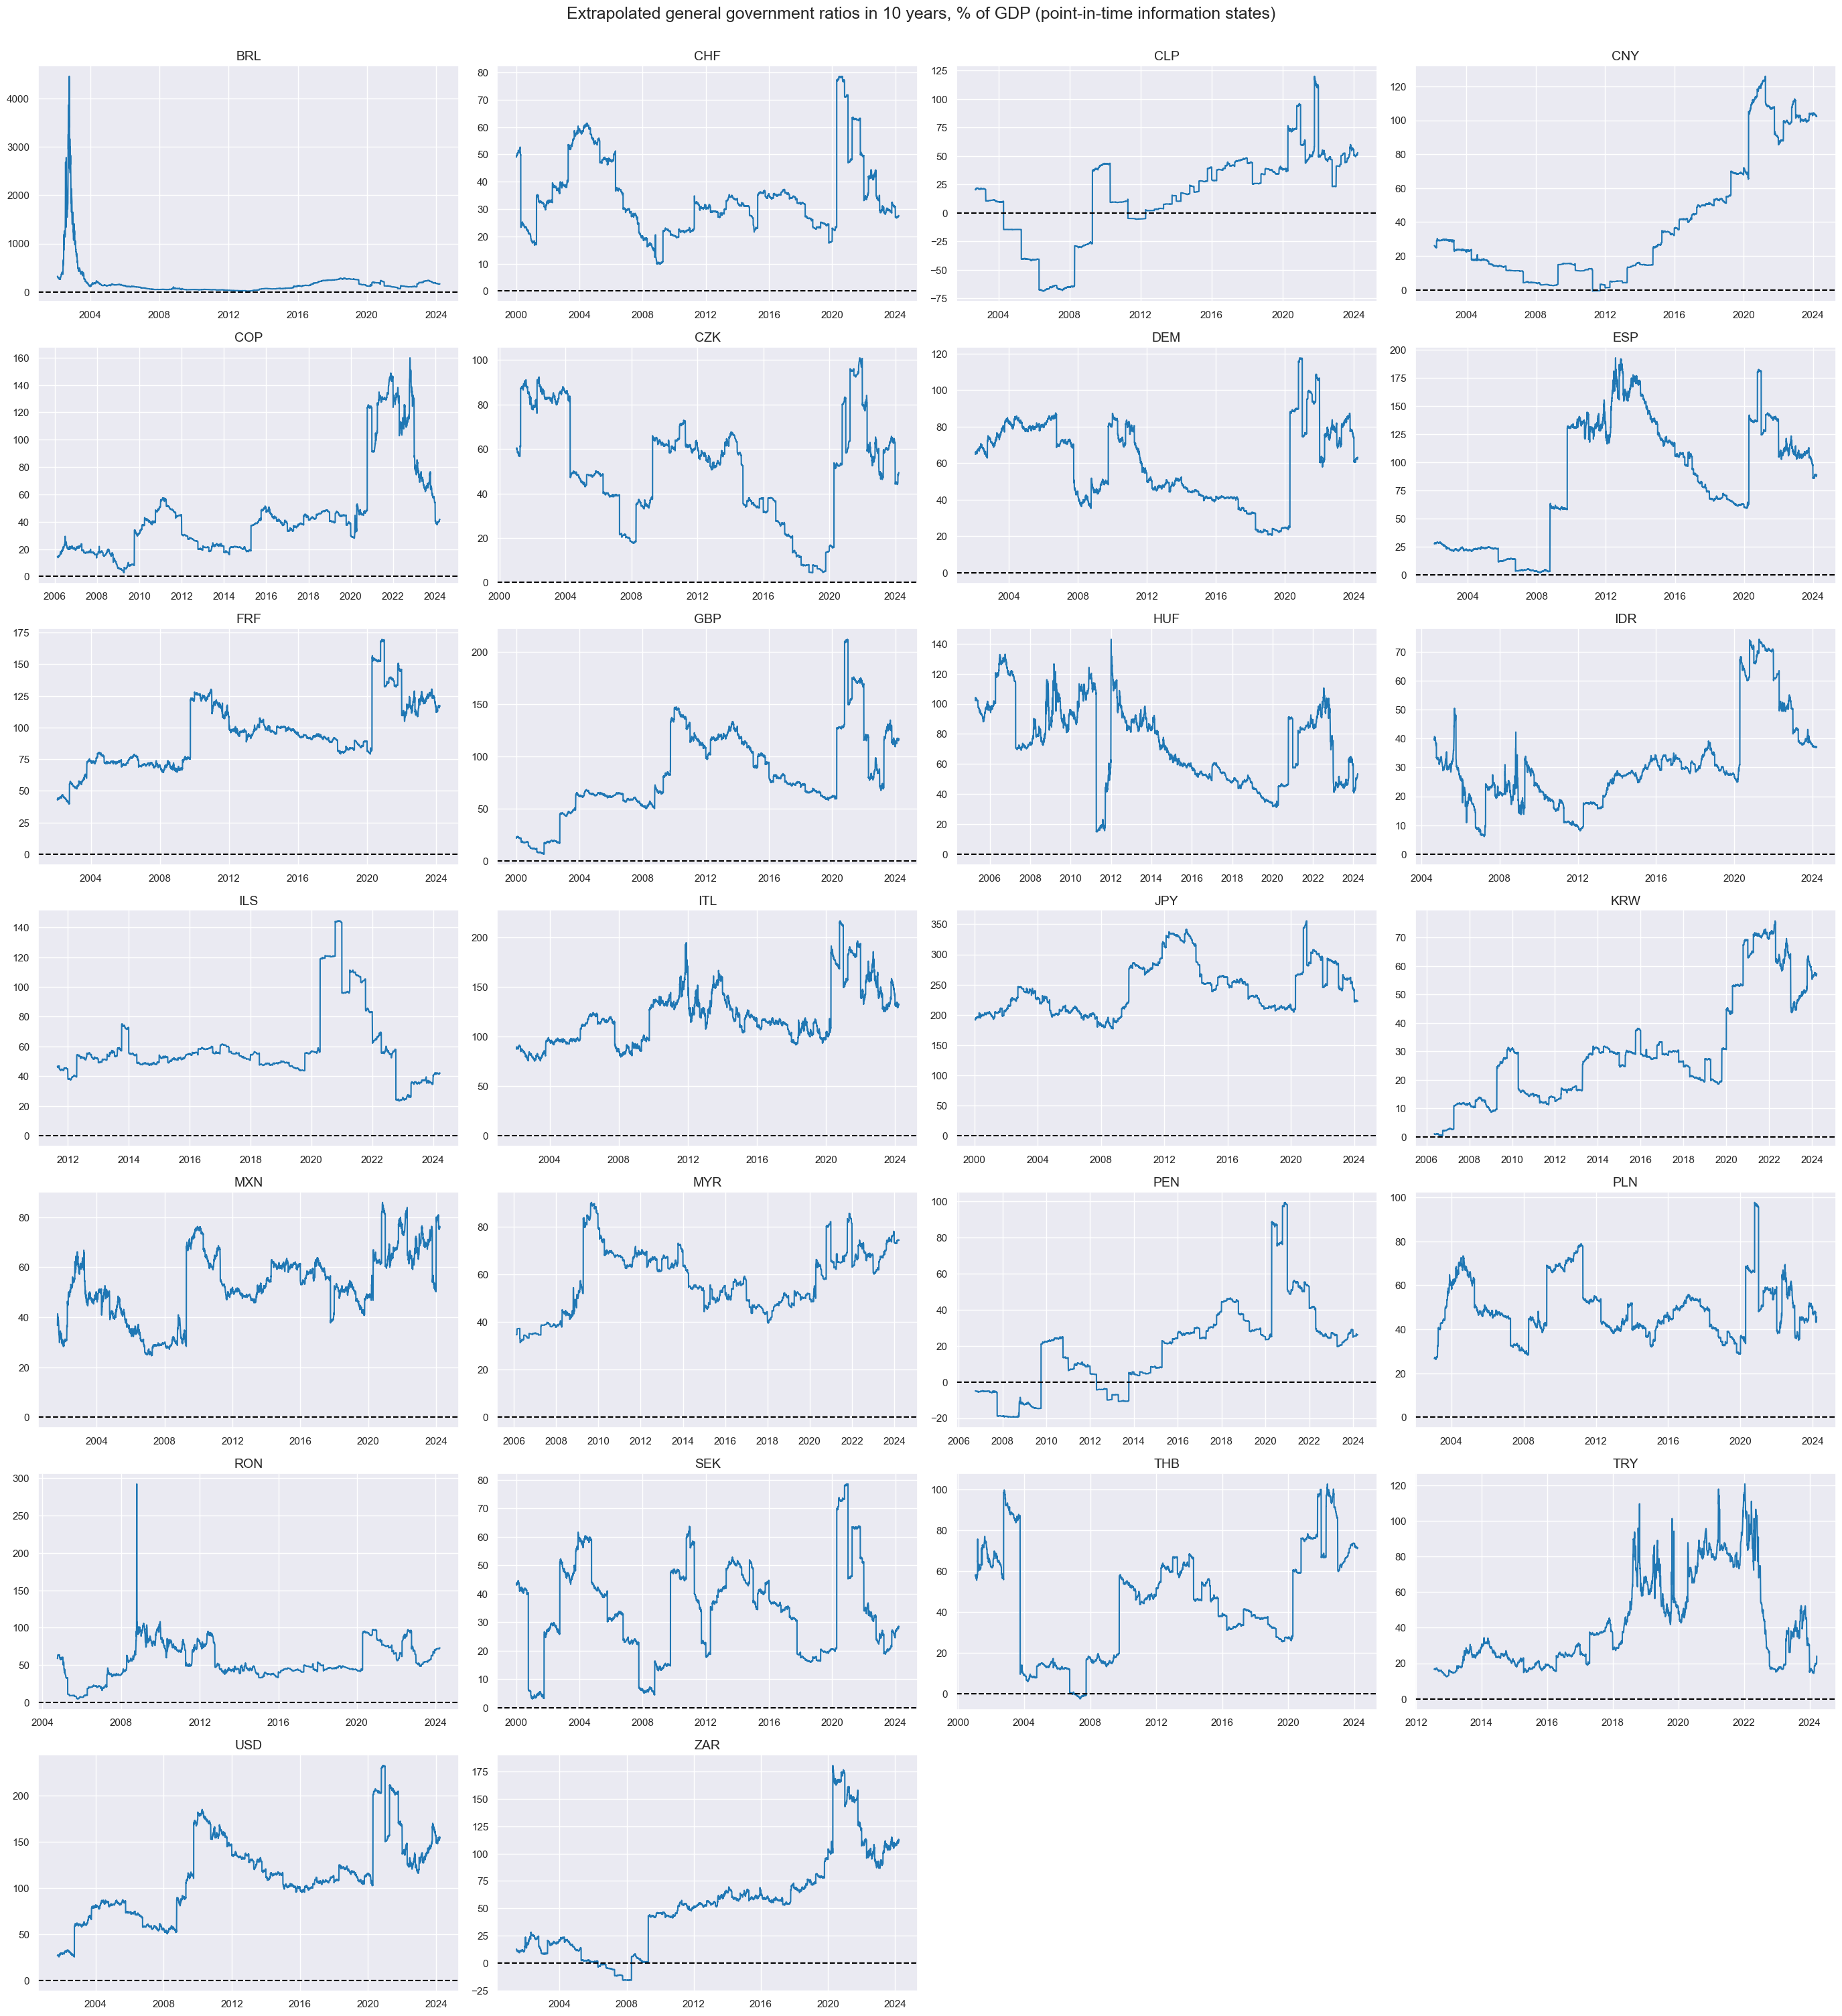

In [10]:
sdate = "2000-01-01"

msp.view_timelines(
    dfx,
    xcats="GGDGDPRATIOX10_NSA",
    cids=cids,
    ncol=4,
    cumsum=False,
    start=sdate,
    same_y=False,
    all_xticks=True,
    title="Extrapolated general government ratios in 10 years, % of GDP (point-in-time information states)",
    
)

To test various hypotheses on the relationship between mechanical sustainability indicators and CDS returns, we look at short-term and medium-term trends in the information states of extrapolated general government debt ratios.
-   Biweekly trend: This is the difference between the information state on the debt ratio of the latest day and the previous two weeks (10 trading days), winsorized at 10%-points.
-   Monthly trend: This is the difference between the information state on the debt ratio of the latest day and the previous month (21 trading days), winsorized at 10%-points.
-   Annual trend: This is the difference between the information state on the debt ratio of the latest week (5 trading days) and the previous year (252 trading days), winsorized at 20%-points.
-   Bi-annual trend: This is the difference between the information state on the debt ratio of the latest month (21 trading days) and the previous 2 years (504 trading days), winsorized at 20%-points.

The purpose of winsorization is to avoid the dominance of individual episodes in the sample and to weed out data outliers. This is done with the standard python [`.clip()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.clip.html) function, where all values below the minimum threshold (10% in our case) are set to a threshold value; and all values above the threshold (10% in our case) will be set to it.

In [11]:
cidx = cids
calcs = [
    "GGDGDPRATIOX10_NSA_21Dv504D = GGDGDPRATIOX10_NSA.rolling(21).mean() - GGDGDPRATIOX10_NSA.shift(21).rolling(504).mean()",
    "GGDGDPRATIOX10_NSA_21Dv504DW = GGDGDPRATIOX10_NSA_21Dv504D.clip(lower=-20, upper=20)",
    "GGDGDPRATIOX10_NSA_5Dv252D = GGDGDPRATIOX10_NSA.rolling(5).mean() - GGDGDPRATIOX10_NSA.shift(5).rolling(252).mean()",
    "GGDGDPRATIOX10_NSA_5Dv252DW = GGDGDPRATIOX10_NSA_5Dv252D.clip(lower=-20, upper=20)",
    "GGDGDPRATIOX10_NSA_1Dv10D = GGDGDPRATIOX10_NSA.rolling(1).mean() - GGDGDPRATIOX10_NSA.shift(1).rolling(10).mean()",
    "GGDGDPRATIOX10_NSA_1Dv10DW = GGDGDPRATIOX10_NSA_1Dv10D.clip(lower=-10, upper=10)",
    "GGDGDPRATIOX10_NSA_1Dv21D = GGDGDPRATIOX10_NSA.rolling(1).mean() - GGDGDPRATIOX10_NSA.shift(1).rolling(21).mean()",
    "GGDGDPRATIOX10_NSA_1Dv21DW = GGDGDPRATIOX10_NSA_1Dv21D.clip(lower=-10, upper=10)",
]
dfa = msp.panel_calculator(dfx, calcs=calcs, cids=cidx)
dfx = msm.update_df(dfx, dfa)

### Targets

The target of the analysis is Sovereign CDS returns: 5-year maturity across 27 countries. With the help of [`view_ranges()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#visualize-panel-distributions-with-view-ranges) and [`view_timelines()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#visualize-panel-time-series-with-view-timelines) from the `macrosynergy` package we plot the CDS return separately for each country:

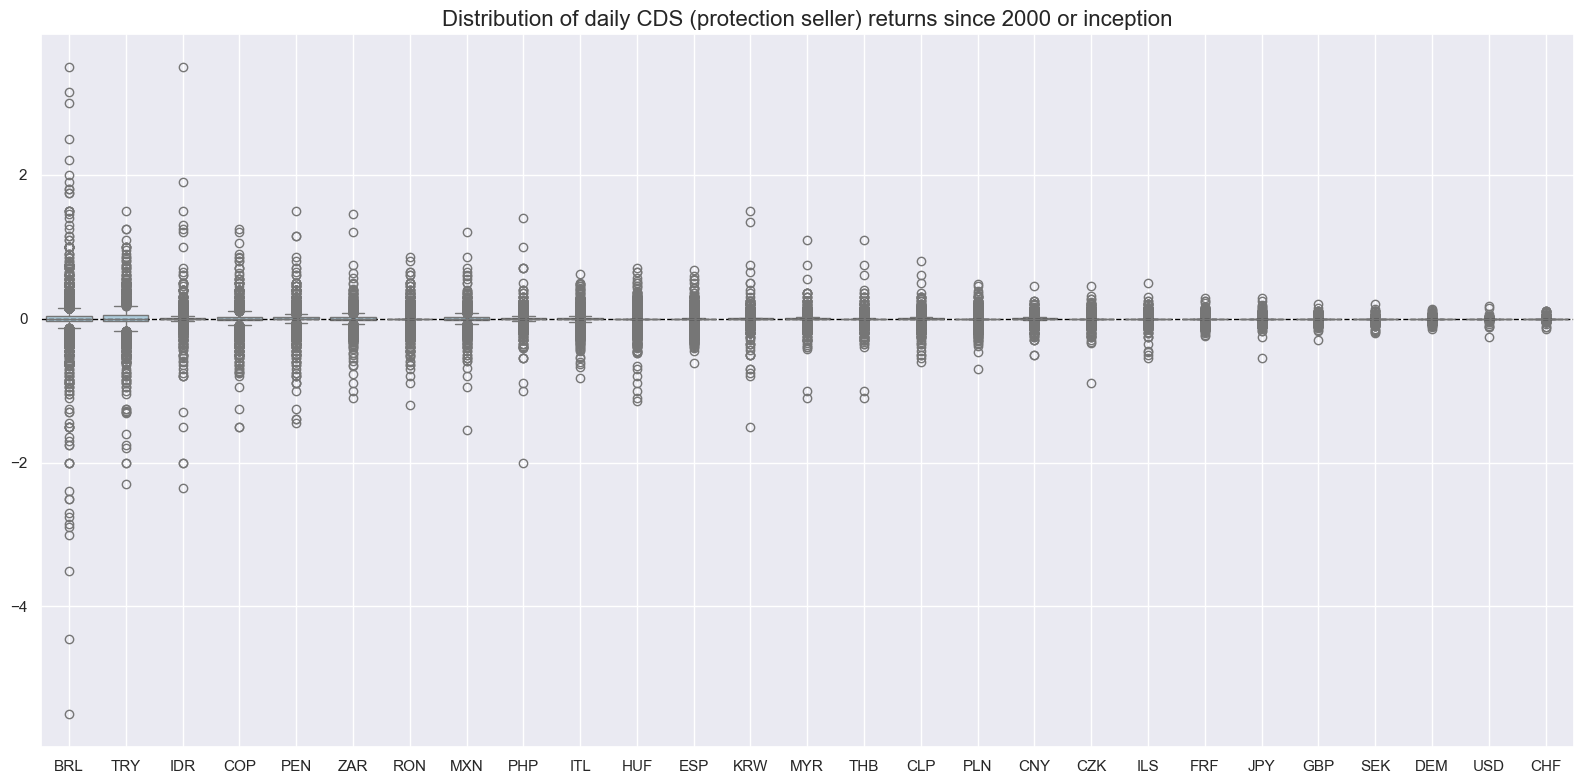

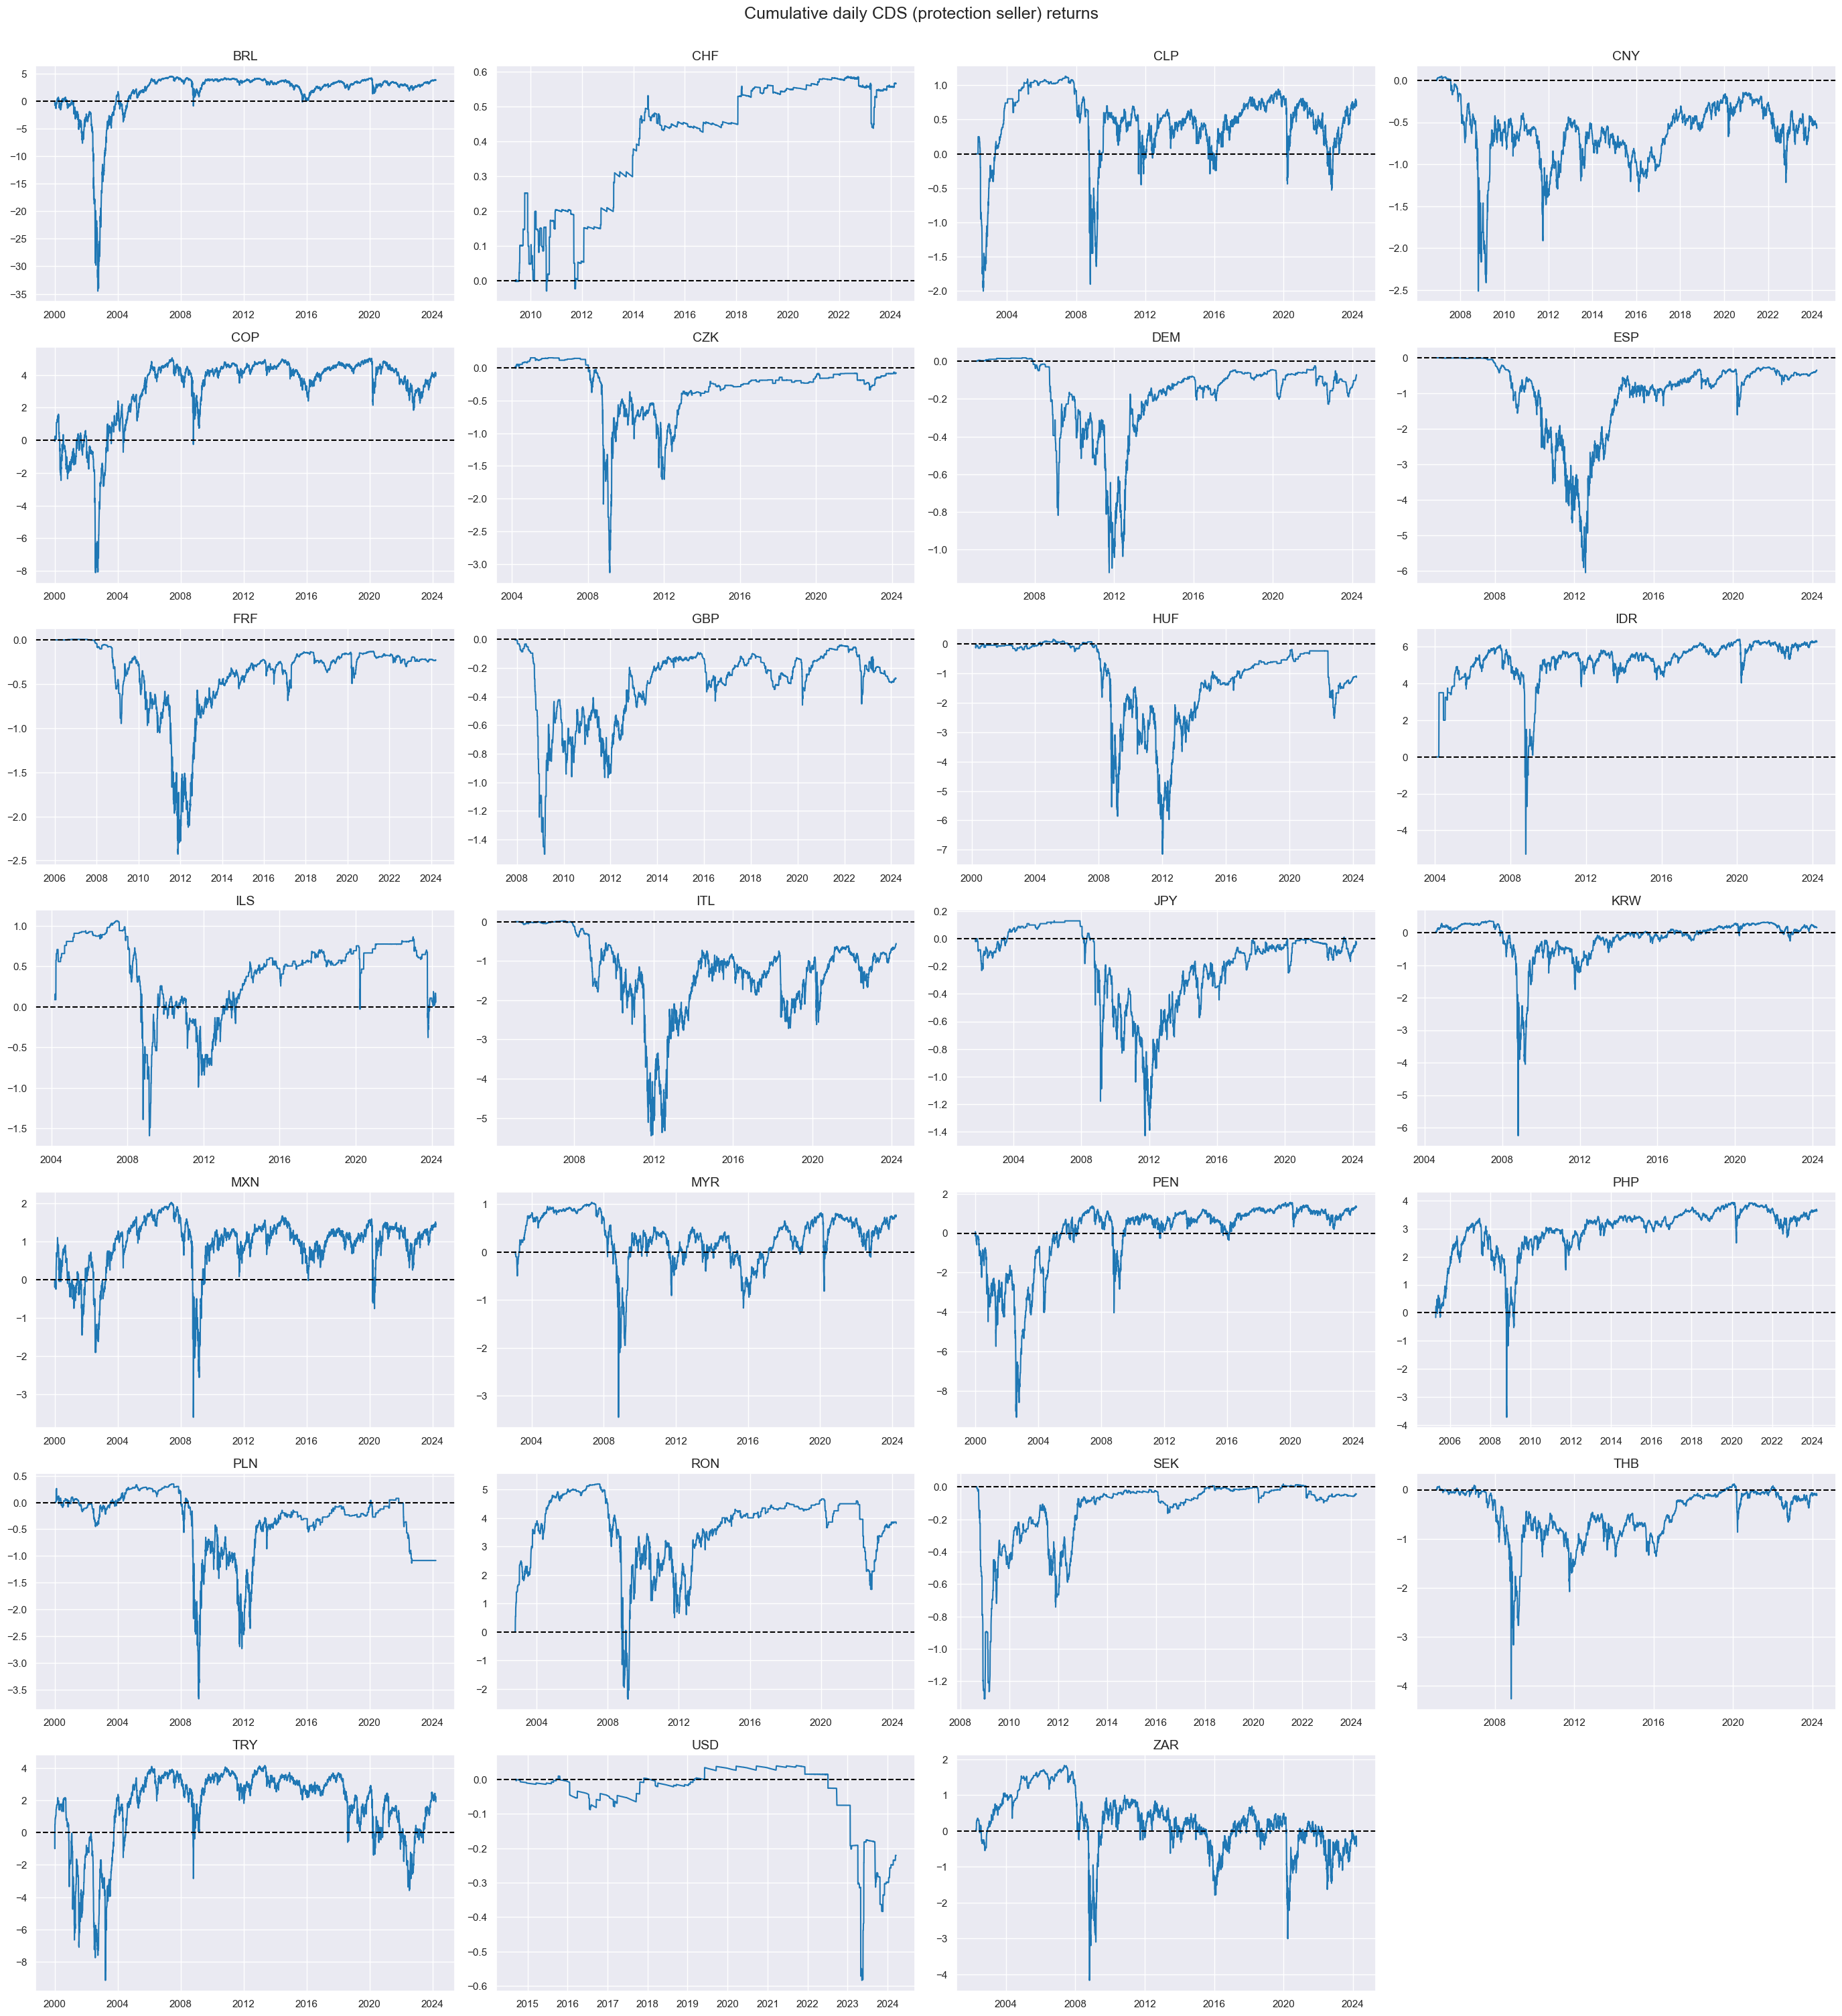

In [12]:
xcatx = ["CDS05YXR_NSA"]
cidx=cids
sdate = "2000-01-01"

msp.view_ranges(
    dfx,
    cids=cidx,
    xcats=xcatx,
    kind="box",
    sort_cids_by="std",
    start="2000-01-01",
    title="Distribution of daily CDS (protection seller) returns since 2000 or inception"
)

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=4,
    cumsum=True,
    start=sdate,
    same_y=False,
    all_xticks=True,
    title="Cumulative daily CDS (protection seller) returns",

)

Volatility targeting is a simple way of imposing some risk management on CDS positions. It naturally evens out return variance across sovereigns. With the help of [`view_ranges()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#visualize-panel-distributions-with-view-ranges) and [`view_timelines()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#visualize-panel-time-series-with-view-timelines) from the `macrosynergy` package we plot the CDS excess returns for 10% vol target: 5-year maturity separately for each country:

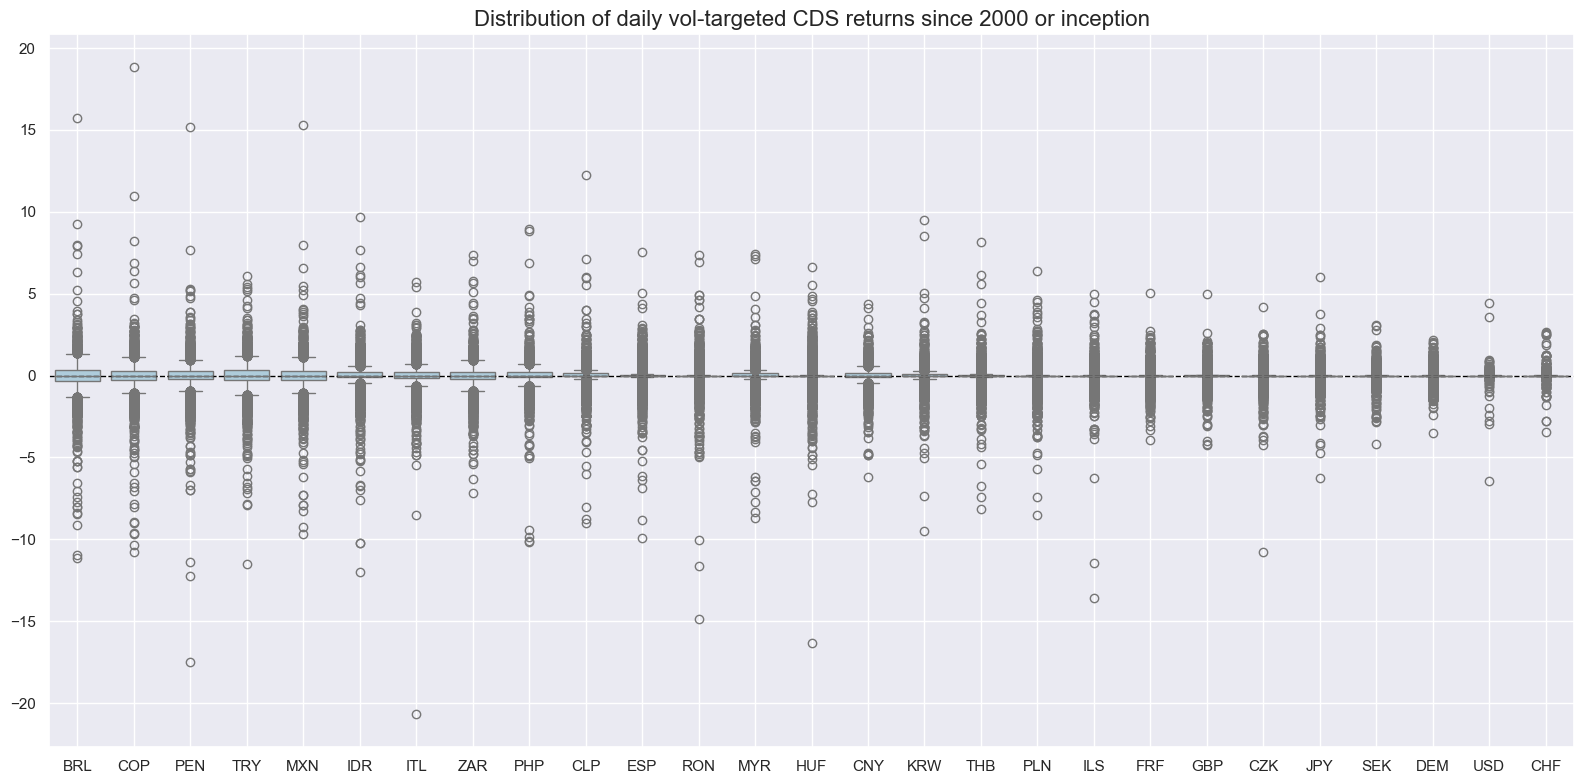

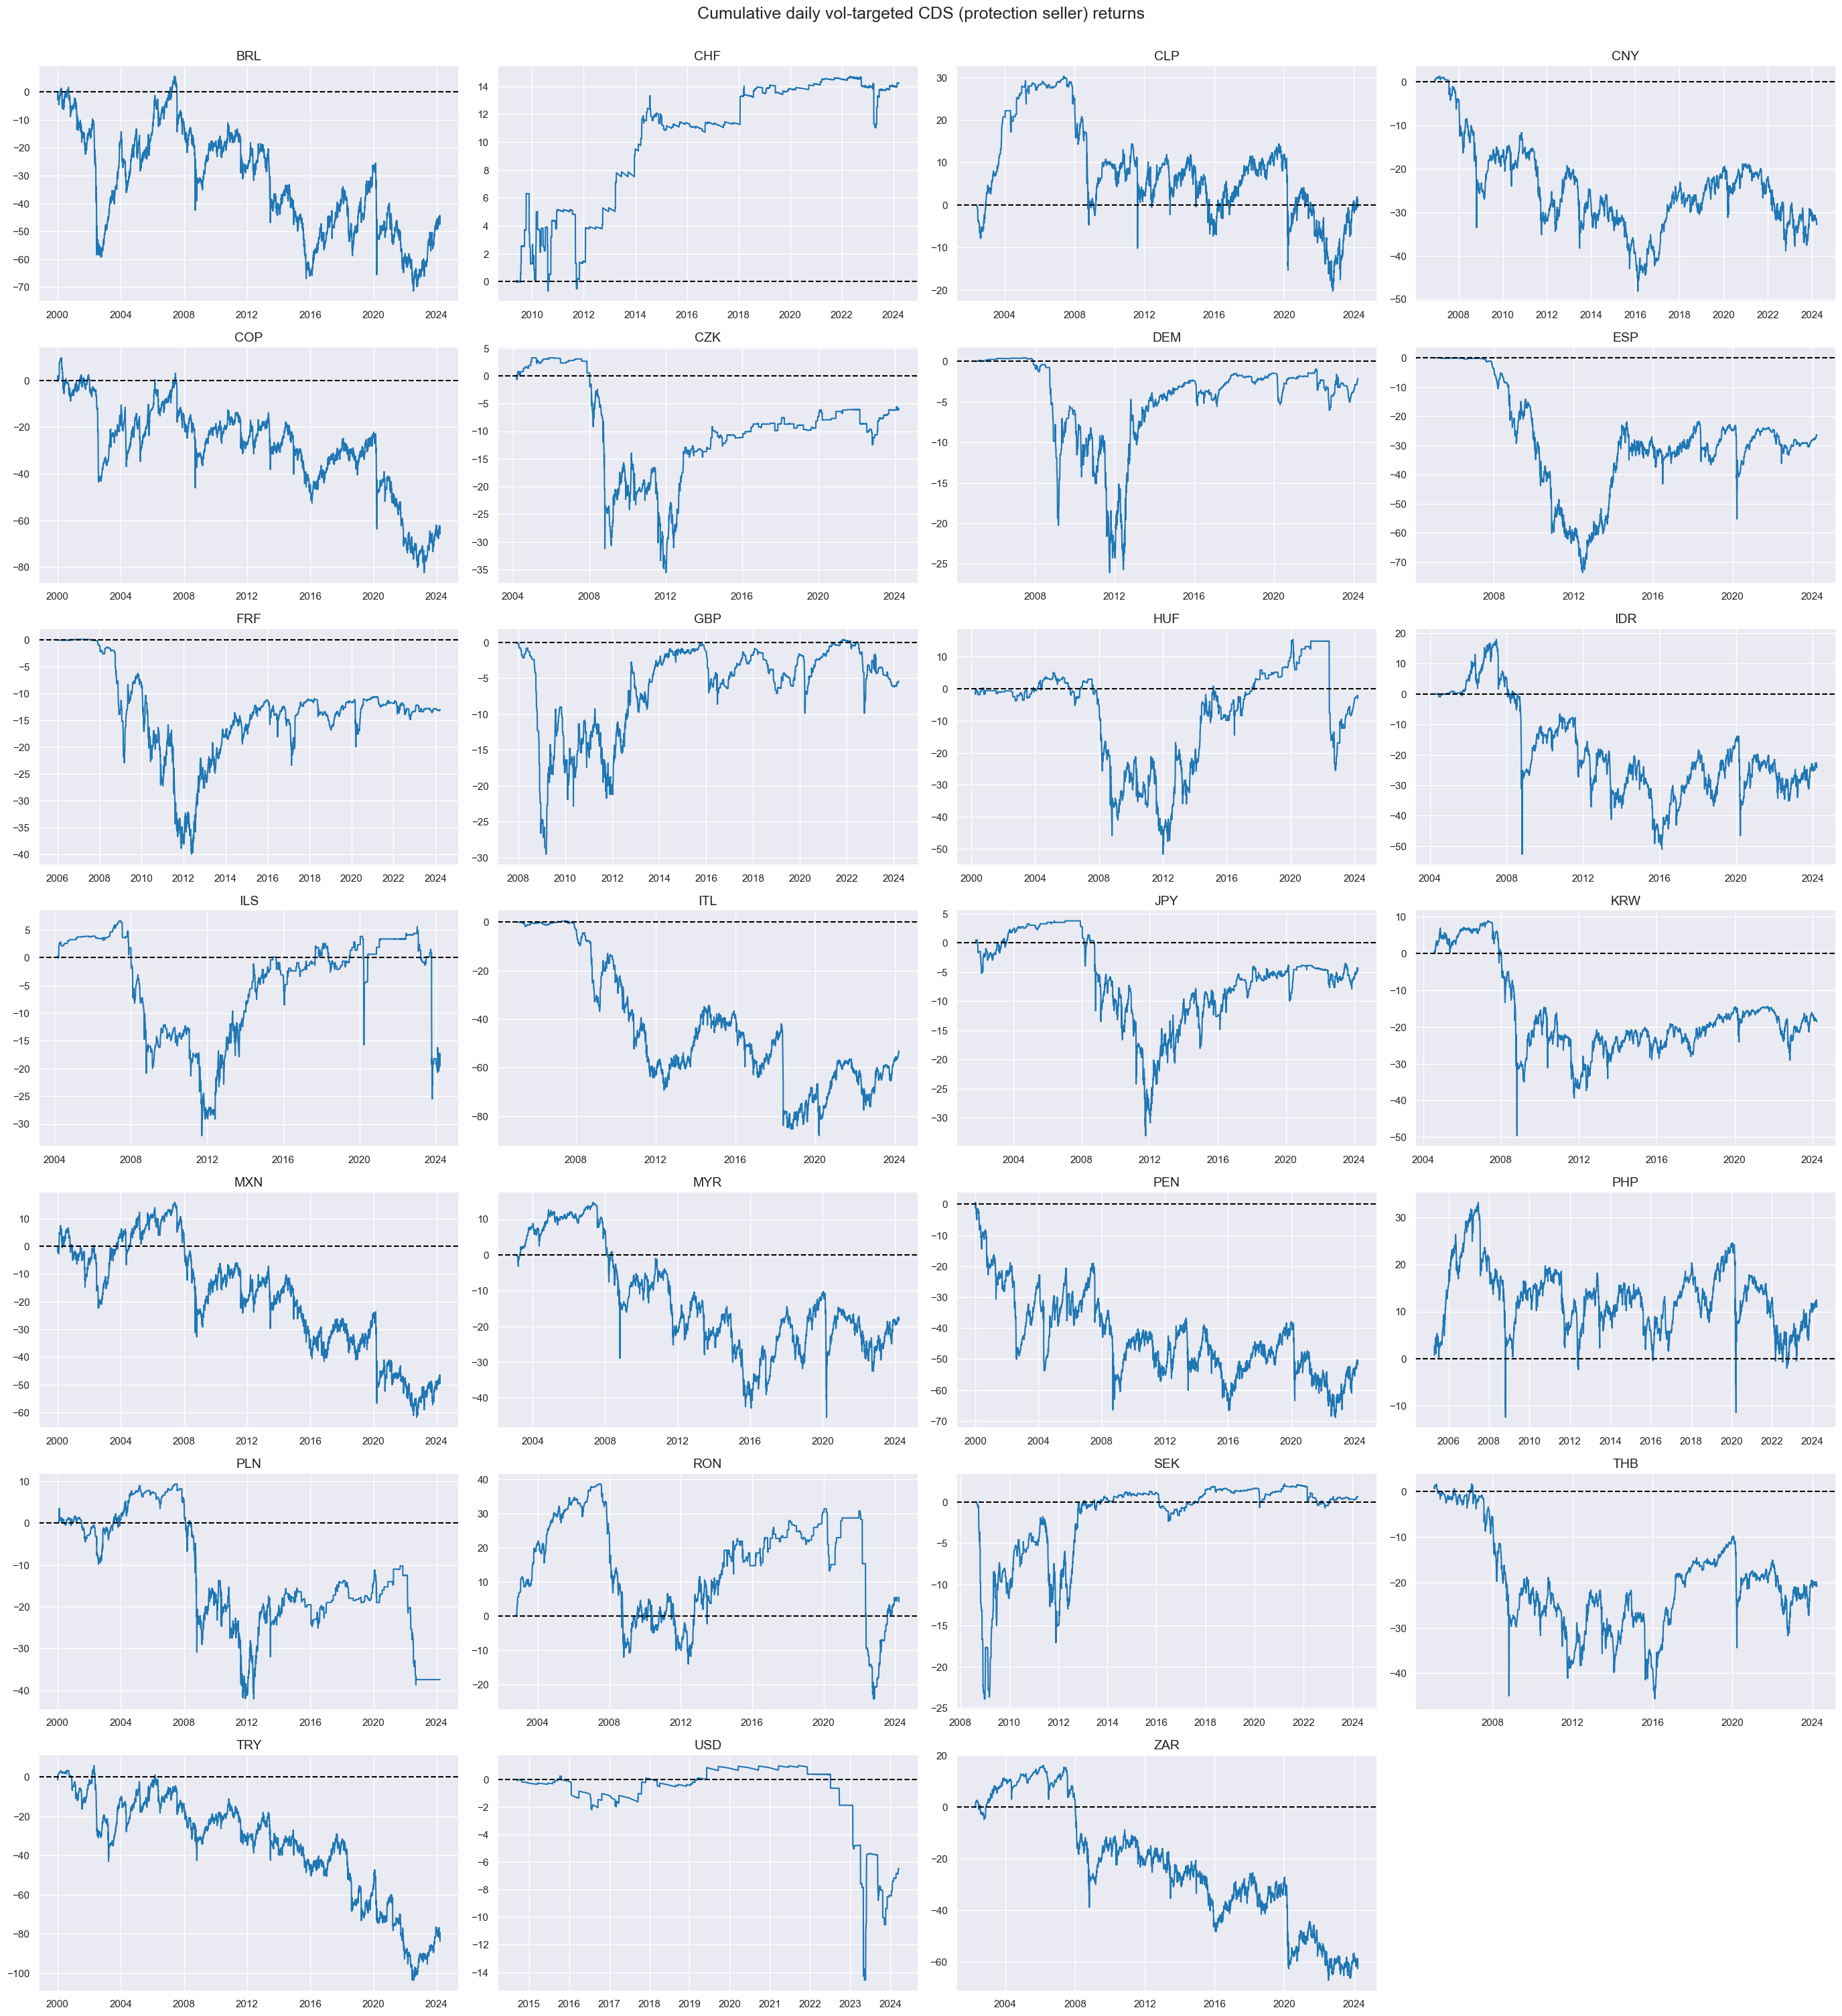

In [13]:
xcatx = ["CDS05YXR_VT10"]
cidx=cids

msp.view_ranges(
    dfx,
    cids=cidx,
    xcats=xcatx,
    kind="box",
    sort_cids_by="std",
    title="Distribution of daily vol-targeted CDS returns since 2000 or inception",
    start="2000-01-01",
)

msp.view_timelines(
    dfx,
    xcats=xcatx,
    cids=cidx,
    ncol=4,
    cumsum=True,
    start=sdate,
    same_y=False,
    all_xticks=True,
    title="Cumulative daily vol-targeted CDS (protection seller) returns",
    )

## Value checks

### Short-term sustainability effects

#### Specs and panel test

In this section, we specify signals and the target for the first hypothesis. Here, we test a simple idea that deterioration in debt sustainability indicators coincides with negative CDS returns. In particular, one would expect that an increase in the extrapolated government debt ratio increases default risk and the price for protection. As the main signal we choose the monthly trend: This is the difference between the information state on the debt ratio of the latest day and the mean of the previous month (21 trading days), winsorized at 10%-points (`GGDGDPRATIOX10_NSA_1Dv21DW`). We test as alternative signals windorized bi-weekly trend `GGDGDPRATIOX10_NSA_1Dv10DW`
As target, we keep [Sovereign CDS returns](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Sovereign%20CDS%20returns.php)

In [14]:
ms = "GGDGDPRATIOX10_NSA_1Dv21DW"
oths = [
    "GGDGDPRATIOX10_NSA_1Dv10DW",
]

targ = "CDS05YXR_NSA"
cidx = list(set(cids) - set(["PHP"]))
start = "2002-01-01"

dict_sse = {
    "sig": ms,
    "rivs": oths,
    "targ": targ,
    "cidx": cidx,
    "start": start,
    "black": None,
    "srr": None,
    "pnls": None,
}

  We use [`CategoryRelations()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#investigate-relations-between-panels-with-categoryrelations) function for quick visualization and analysis of two categories, in particular, sustainability debt indicator "GGDGDPRATIOX10_NSA_1Dv21DW" and subsequent [Sovereign CDS returns](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Sovereign%20CDS%20returns.php). The `.reg_scatter()` method is convenient for visualizing the relationship between two categories, including the strength of the linear association and any potential outliers. It includes a regression line with a 95% confidence interval, which can help assess the significance of the relationship:

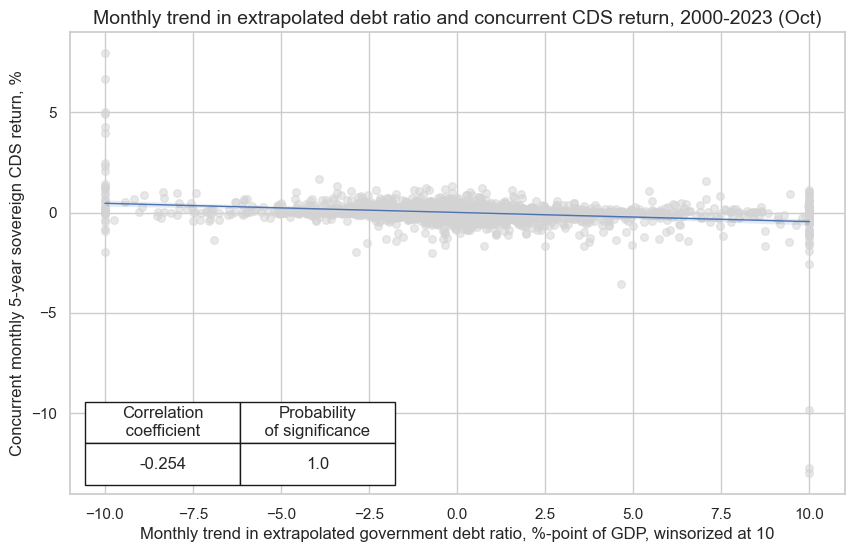

In [15]:
dix = dict_sse

sig = dix["sig"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

crx = msp.CategoryRelations(
    dfx,
    xcats=[sig, targ],
    cids=cidx,
    freq="M",
    lag=0,
    xcat_aggs=["last", "sum"],
    start=start,
    blacklist=blax,
)
crx.reg_scatter(
    labels=False,
    coef_box="lower left",
    title="Monthly trend in extrapolated debt ratio and concurrent CDS return, 2000-2023 (Oct)",
    xlab="Monthly trend in extrapolated government debt ratio, %-point of GDP, winsorized at 10",
    ylab="Concurrent monthly 5-year sovereign CDS return, %",
    size=(10, 6),
    prob_est="map",
)

This negative correlation increases dramatically, if we leave all the outliers that are filtered out by standard winsorization, i.e. use non-windorized version of monthly sustainability indicator `GGDGDPRATIOX10_NSA_1Dv21D` 

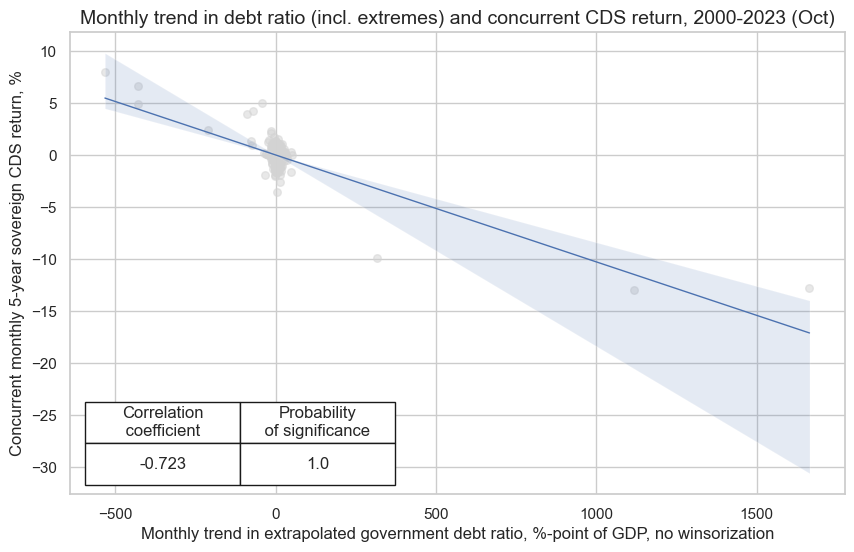

In [16]:
dix = dict_sse

sig = "GGDGDPRATIOX10_NSA_1Dv21D" 
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

crx = msp.CategoryRelations(
    dfx,
    xcats=[sig, targ],
    cids=cidx,
    freq="M",
    lag=0,
    xcat_aggs=["last", "sum"],
    start=start,
    blacklist=blax,
)
crx.reg_scatter(
    labels=False,
    coef_box="lower left",
    title="Monthly trend in debt ratio (incl. extremes) and concurrent CDS return, 2000-2023 (Oct)",
    xlab="Monthly trend in extrapolated government debt ratio, %-point of GDP, no winsorization",
    ylab="Concurrent monthly 5-year sovereign CDS return, %",
    size=(10, 6),
    prob_est="map",
)

The second tested hypothesis is that conscientious following of short-term trends in sustainability indicators offers an information advantage and predicts subsequent CDS returns. In particular, short-term trends in extrapolated debt ratios are expected to predict subsequent short-protection CDS returns negatively. We introduce the `lag=1` within the `CategoryRelations()` function.

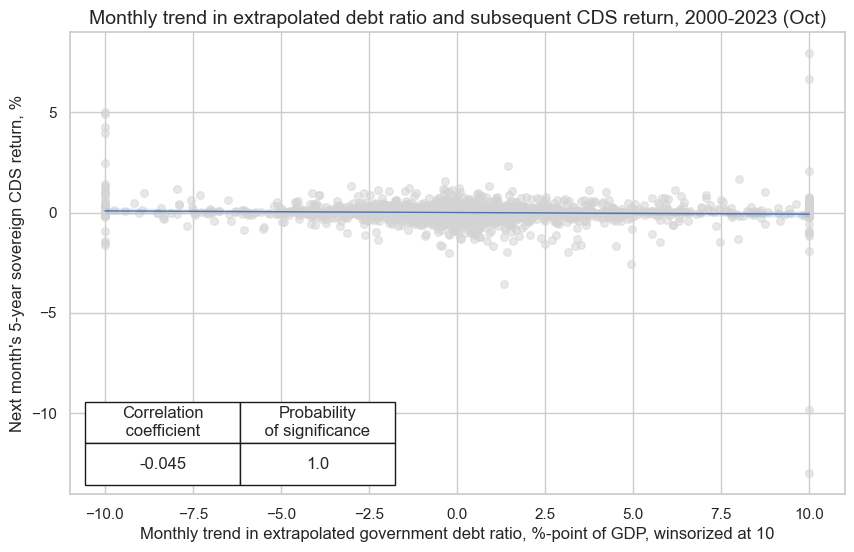

In [17]:

dix = dict_sse

sig = dix["sig"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

crx = msp.CategoryRelations(
    dfx,
    xcats=[sig, targ],
    cids=cidx,
    freq="M",
    lag=1,
    xcat_aggs=["last", "sum"],
    start=start,
    blacklist=blax,
)
crx.reg_scatter(
    labels=False,
    coef_box="lower left",
    title="Monthly trend in extrapolated debt ratio and subsequent CDS return, 2000-2023 (Oct)",
    xlab="Monthly trend in extrapolated government debt ratio, %-point of GDP, winsorized at 10",
    ylab="Next month's 5-year sovereign CDS return, %",
    size=(10, 6),
    prob_est="map",
)

#### Accuracy and correlation check

The [`SignalReturnRelations`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#signalreturnrelations) class from the macrosynergy.signal module is specifically designed to analyze, visualize, and compare the relationships between panels of trading signals and panels of subsequent returns.

In [18]:
dix = dict_sse

sig = dix["sig"]
rivs = dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

srr = mss.SignalReturnRelations(
    dfx,
    cids=cidx,
    sigs=[sig] + rivs,
    sig_neg=[True] + [True] * len(rivs),
    rets=targ,
    freqs="M",
    start=start,
    blacklist=blax,
)

dix["srr"] = srr
srrx = dix["srr"]

For a comparative overview of the signal-return relationship across the main and rival signals, one can use the `signals_table()` method.

In [19]:
display(srrx.signals_table().sort_index().astype("float").round(3))

accuracy  bal_accuracy  pos_sigr  pos_retr  \
GGDGDPRATIOX10_NSA_1Dv10DW_NEG     0.524         0.522     0.531     0.535   
GGDGDPRATIOX10_NSA_1Dv21DW_NEG     0.510         0.508     0.518     0.535   

                                pos_prec  neg_prec  pearson  pearson_pval  \
GGDGDPRATIOX10_NSA_1Dv10DW_NEG     0.555     0.488    0.050         0.000   
GGDGDPRATIOX10_NSA_1Dv21DW_NEG     0.543     0.473    0.045         0.001   

                                kendall  kendall_pval    auc  
GGDGDPRATIOX10_NSA_1Dv10DW_NEG    0.037         0.000  0.522  
GGDGDPRATIOX10_NSA_1Dv21DW_NEG    0.009         0.327  0.508

#### Naive PnL

[`NaivePnl()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#naivepnl) class is designed to provide a quick and simple overview of a stylized PnL profile of a set of trading signals. The class carries the label naive because its methods do not consider transaction costs or position limitations, such as risk management considerations. This is deliberate because costs and limitations are specific to trading size, institutional rules, and regulations. 

Important options within NaivePnl() function include: 

- `zn_score_pan` option, which transforms raw signals into z-scores around zero value based on the whole panel. The neutral level & standard deviation will use the cross-section of panels. zn-score here means standardized score with zero being the neutral level and standardization through division by mean absolute value. 

- rebalancing frequency (`rebal_freq`) for positions according to signal is chosen monthly,

- rebalancing slippage (`rebal_slip`) in days is 1, which means that it takes one day to rebalance the position and that the new position produces PnL from the second day after the signal has been recorded,

- threshold value (`thresh`) beyond which scores are winsorized, i.e., contained at that threshold. This is often realistic, as risk management and the potential of signal value distortions typically preclude outsized and concentrated positions within a strategy. We apply a threshold of 2.

The function below creates two types of PnLs: "PZN", `zn_score_pan` (transforms raw signals into z-scores around zero value based on cross-section alone), and "BIN", `binary` (transforms the category values into simple long/shorts (1/-1) signals). We also create long only PnL, labeling it "Short protection/ long credit only"

In [20]:

dix = dict_sse

sigx = [dix["sig"]] + dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

naive_pnl = msn.NaivePnL(
    dfx,
    ret="CDS05YXR_VT10", # targ,
    sigs=sigx,
    cids=cidx,
    start=start,
    blacklist=blax,
    bms=["USD_EQXR_NSA"],
)

dict_pnls = {
    "PZN": "zn_score_pan", 
    "BIN": "binary",
}

for k, v in dict_pnls.items():
    for sig in sigx:
        naive_pnl.make_pnl(
            sig,
            sig_neg=True,
            sig_add=0,
            sig_op=v,
            thresh=2,
            rebal_freq="monthly",
            vol_scale=10,
            rebal_slip=1,
            pnl_name=sig + f"_{k}",
        )

naive_pnl.make_long_pnl(vol_scale=10, label="Short protection/ long credit only")
dix["pnls"] = naive_pnl

The [`plot_pnls()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#plot-pnls) method of the `NaivePnl()` class is used to plot a line chart of cumulative PnL 

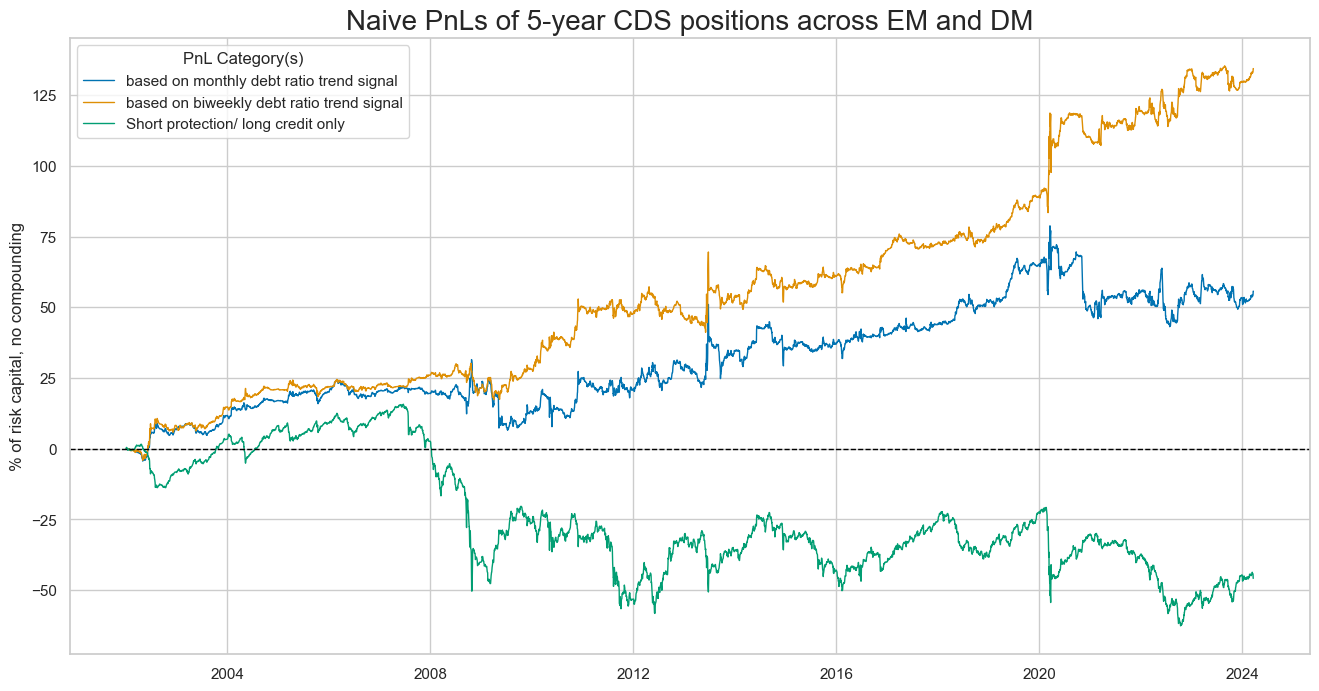

In [21]:

dix = dict_sse

start = dix["start"]
sigx = [dix["sig"]] + dix["rivs"]

naive_pnl = dix["pnls"]

dict_labels={
"GGDGDPRATIOX10_NSA_1Dv21DW_PZN": "based on monthly debt ratio trend signal",
"GGDGDPRATIOX10_NSA_1Dv10DW_PZN": "based on biweekly debt ratio trend signal",
"Short protection/ long credit only": "Short protection/ long credit only"}

pnls = [s + "_" + "PZN" for s in sigx] + ["Short protection/ long credit only"]
naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start,
    title="Naive PnLs of 5-year CDS positions across EM and DM",
    xcat_labels=dict_labels,
    figsize=(16, 8),
)

The stronger value generation of the biweekly trend may indicate that time is of the essence in trading debt sustainability. Unlike other economic trends, short-term changes in debt sustainability depend largely on market conditions themselves and, hence, are more easily watched by market participants. Simply put, the information advantage plausibly wears off faster than in the case of pure macroeconomic data.

In [22]:
dix = dict_sse

start = dix["start"]
sigx = [dix["sig"]] + dix["rivs"]
naive_pnl = dix["pnls"]
pnls = [s + "_" + "PZN" for s in sigx] + ["Short protection/ long credit only"]

df_eval = naive_pnl.evaluate_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start,
)



The method `evaluate_pnls()` returns a small dataframe of key PnL statistics for the tested strategies

In [23]:
display(df_eval.transpose())

Return (pct ar) St. Dev. (pct ar)  \
xcat                                                                   
GGDGDPRATIOX10_NSA_1Dv10DW_PZN            6.049922              10.0   
GGDGDPRATIOX10_NSA_1Dv21DW_PZN            2.507162              10.0   
Short protection/ long credit only       -2.064319              10.0   

                                   Sharpe Ratio Sortino Ratio Max 21-day draw  \
xcat                                                                            
GGDGDPRATIOX10_NSA_1Dv10DW_PZN         0.604992      0.958702      -13.480469   
GGDGDPRATIOX10_NSA_1Dv21DW_PZN         0.250716       0.36799      -18.697661   
Short protection/ long credit only    -0.206432     -0.268045       -33.32125   

                                   Max 6-month draw USD_EQXR_NSA correl  \
xcat                                                                      
GGDGDPRATIOX10_NSA_1Dv10DW_PZN           -17.575419           -0.126604   
GGDGDPRATIOX10_NSA_1Dv21DW_PZN            -22.77438           -0.096497   
Short protection/ long credit only       -44.039903            0.425381   

                                   Traded Months  
xcat                                              
GGDGDPRATIOX10_NSA_1Dv10DW_PZN               267  
GGDGDPRATIOX10_NSA_1Dv21DW_PZN               267  
Short protection/ long credit only           267

### Medium-term sustainability effects

#### Specs and panel test

Here, we test the third hypothesis, which draws on the characteristic of credit exposure being similar to a short option position with limited liquidity. The main signal is the windorized (at 20%) annual trend, and the alternative signal is the windorized (at 20%) bi-annual trend. As target, we keep [Sovereign CDS returns](https://academy.macrosynergy.com/academy/Themes/Generic%20returns/_build/html/notebooks/Sovereign%20CDS%20returns.php) 

In [24]:
ms = 'GGDGDPRATIOX10_NSA_5Dv252DW'
oths = ['GGDGDPRATIOX10_NSA_21Dv504DW']

targ = "CDS05YXR_NSA"
cidx = list(set(cids_dm) - set(["PHP"]))
start = "2008-01-01"

dict_mse = {
    "sig": ms,
    "rivs": oths,
    "targ": targ,
    "cidx": cidx,
    "start": start,
    "black": None,
    "srr": None,
    "pnls": None,
}

GGDGDPRATIOX10_NSA_5Dv252DW misses: ['PHP'].


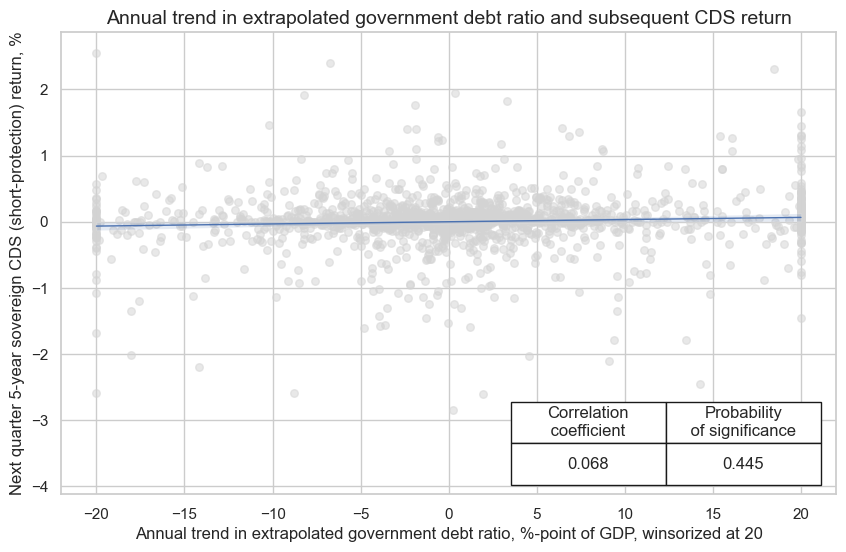

In [25]:
dix = dict_mse

sig = dix["sig"]
targ = dix["targ"]
cidx = cids # dix["cidx"]
start = dix["start"]

crx = msp.CategoryRelations(
    dfx,
    xcats=[sig, targ],
    cids=cidx,
    freq="Q",
    lag=1,
    xcat_aggs=["last", "sum"],
    start=start,
    blacklist=blax,
)
crx.reg_scatter(
    labels=False,
    coef_box="lower right",
    title="Annual trend in extrapolated government debt ratio and subsequent CDS return",
    xlab="Annual trend in extrapolated government debt ratio, %-point of GDP, winsorized at 20",
    ylab="Next quarter 5-year sovereign CDS (short-protection) return, %",
    size=(10, 6),
    prob_est="map",
)

While there is a positive relation between past annual and biannual debt ratio trends and subsequent (quarterly) CDS short-protection returns, it has not been significant for the full panel of cross sections (the plot above). The positive relationship has been significant only for the developed markets ever since that market became more liquid in the late 2000s (see below).  

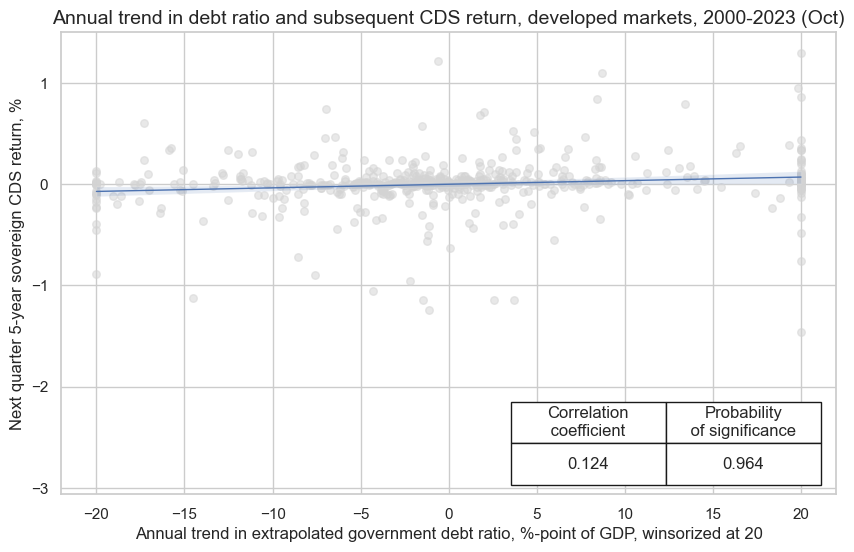

In [26]:
dix = dict_mse

sig = dix["sig"]
targ = dix["targ"]
cidx = dix["cidx"]
start = "2008-01-01" #  dix["start"]

crx = msp.CategoryRelations(
    dfx,
    xcats=[sig, targ],
    cids=cids_dm,
    freq="Q",
    lag=1,
    xcat_aggs=["last", "sum"],
    start=start,
    blacklist=blax,
)
crx.reg_scatter(
    labels=False,
    coef_box="lower right",
    title="Annual trend in debt ratio and subsequent CDS return, developed markets, 2000-2023 (Oct)",
    xlab="Annual trend in extrapolated government debt ratio, %-point of GDP, winsorized at 20",
    ylab="Next quarter 5-year sovereign CDS return, %",
    size=(10, 6),
    prob_est="map",
)

#### Accuracy and correlation check

The [`SignalReturnRelations`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#signalreturnrelations) class from the macrosynergy.signal module is specifically designed to analyze, visualize, and compare the relationships between panels of trading signals and panels of subsequent returns.

In [27]:

dix = dict_mse

sig = dix["sig"]
rivs = dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

srr = mss.SignalReturnRelations(
    dfx,
    cids=cidx,
    sigs=[sig] + rivs,
    rets=targ,
    freqs="M",
    start=start,
    blacklist=blax,
)

dix["srr"] = srr
srrx = dix["srr"]

For a comparative overview of the signal-return relationship across the main and rival signals, one can use the [`signals_table()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#summary-tables) method.

In [28]:
display(srrx.signals_table().sort_index().astype("float").round(3))

accuracy  bal_accuracy  pos_sigr  pos_retr  \
GGDGDPRATIOX10_NSA_21Dv504DW     0.520         0.522     0.432     0.515   
GGDGDPRATIOX10_NSA_5Dv252DW      0.505         0.506     0.452     0.515   

                              pos_prec  neg_prec  pearson  pearson_pval  \
GGDGDPRATIOX10_NSA_21Dv504DW     0.540     0.504    0.039         0.114   
GGDGDPRATIOX10_NSA_5Dv252DW      0.522     0.491    0.043         0.084   

                              kendall  kendall_pval    auc  
GGDGDPRATIOX10_NSA_21Dv504DW    0.048         0.004  0.522  
GGDGDPRATIOX10_NSA_5Dv252DW     0.030         0.068  0.506

#### Naive PnL

As for the testing above, we use [`NaivePnl()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#naivepnl) class, which is designed to provide a quick and simple overview of a stylized PnL profile of a set of trading signals. The class carries the label naive because its methods do not consider transaction costs or position limitations, such as risk management considerations. This is deliberate because costs and limitations are specific to trading size, institutional rules, and regulations.

We use the same options within NaivePnl() function as before: 

- `zn_score_pan` option, which transforms raw signals into z-scores around zero value based on the whole panel. The neutral level & standard deviation will use the cross-section of panels. zn-score here means standardized score with zero being the neutral level and standardization through division by mean absolute value. 

- rebalancing frequency (`rebal_freq`) for positions according to signal is chosen monthly,

- rebalancing slippage (`rebal_slip`) in days is 1, which means that it takes one day to rebalance the position and that the new position produces PnL from the second day after the signal has been recorded,

- threshold value (`thresh`) beyond which scores are winsorized, i.e., contained at that threshold. This is often realistic, as risk management and the potential of signal value distortions typically preclude outsized and concentrated positions within a strategy. We apply a threshold of 2.

We also create long only PnL, labeling it "Short protection/ long credit only" as benchmark


In [29]:
dix = dict_mse

sigx = [dix["sig"]] + dix["rivs"]
targ = dix["targ"]
cidx = dix["cidx"]
blax = dix["black"]
start = dix["start"]

naive_pnl = msn.NaivePnL(
    dfx,
    ret="CDS05YXR_VT10", # targ,
    sigs=sigx,
    cids=cidx,
    start=start,
    blacklist=blax,
    bms=["USD_EQXR_NSA"],
)

for sig in sigx:
    naive_pnl.make_pnl(
        sig,
        sig_neg=False,
        sig_add=0,
        sig_op="zn_score_pan",
        thresh=2,
        rebal_freq="monthly",
        vol_scale=10,
        rebal_slip=1,
        pnl_name=sig + "_PZN",
    )

naive_pnl.make_long_pnl(vol_scale=10, label="Short protection/ long credit only")
dix["pnls"] = naive_pnl

The [`plot_pnls()`](https://academy.macrosynergy.com/academy/Introductions/Introduction%20to%20Macrosynergy%20package/_build/html/Introduction%20to%20Macrosynergy%20package.php#plot-pnls) method of the `NaivePnl()` class is used to plot a line chart of cumulative PnL 

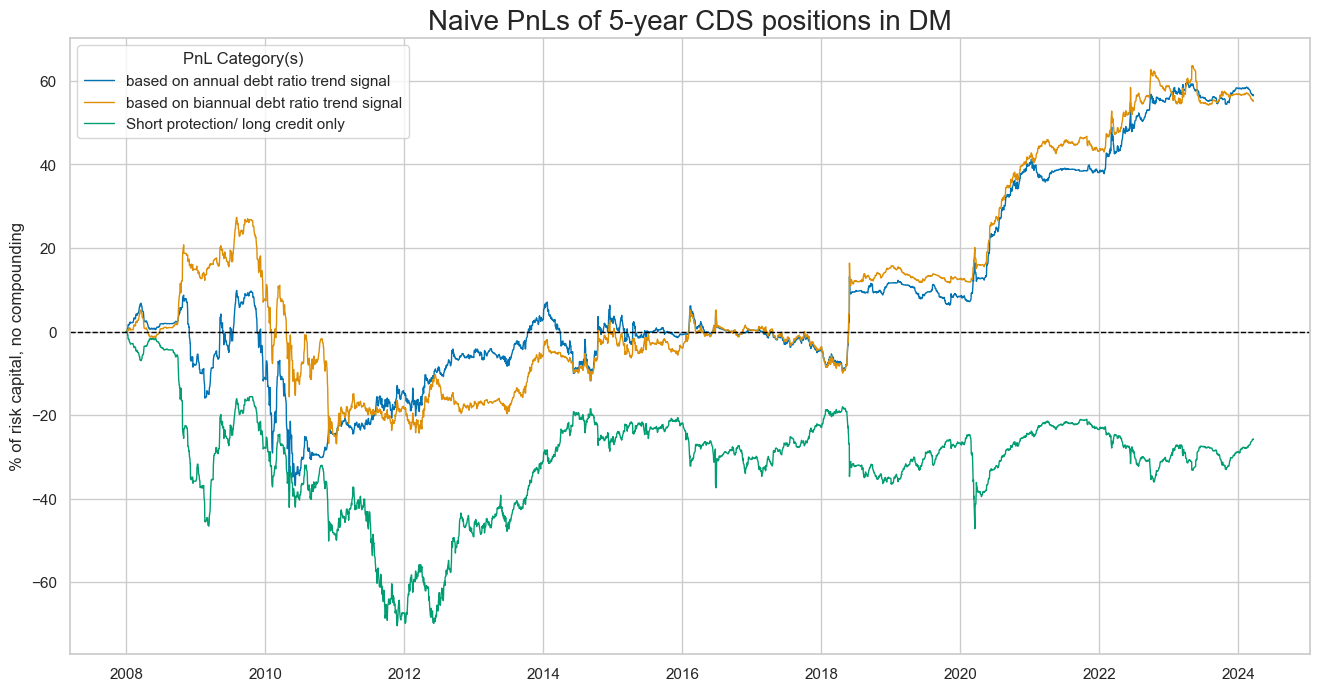

In [30]:
dix = dict_mse

start = dix["start"]
cidx = dix["cidx"]
sigx = [dix["sig"]] + dix["rivs"]

naive_pnl = dix["pnls"]


dict_labels={"GGDGDPRATIOX10_NSA_5Dv252DW_PZN": "based on annual debt ratio trend signal",
             "GGDGDPRATIOX10_NSA_21Dv504DW_PZN": "based on biannual debt ratio trend signal",
             "Short protection/ long credit only": "Short protection/ long credit only"
}


pnls = [s + "_PZN" for s in sigx] + ["Short protection/ long credit only"]
naive_pnl.plot_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start,
    title="Naive PnLs of 5-year CDS positions in DM",
    xcat_labels=dict_labels,
    figsize=(16, 8),
)

The method `evaluate_pnls()` returns a small dataframe of key PnL statistics for the tested strategies

In [31]:
dix = dict_mse

start = dix["start"]
sigx = [dix["sig"]] + dix["rivs"]
naive_pnl = dix["pnls"]
pnls = [s + "_" + "PZN" for s in sigx] + ["Short protection/ long credit only"]

df_eval = naive_pnl.evaluate_pnls(
    pnl_cats=pnls,
    pnl_cids=["ALL"],
    start=start,
)



In [32]:
display(df_eval.transpose())

Return (pct ar) St. Dev. (pct ar)  \
xcat                                                                   
GGDGDPRATIOX10_NSA_21Dv504DW_PZN          3.399817              10.0   
GGDGDPRATIOX10_NSA_5Dv252DW_PZN           3.480696              10.0   
Short protection/ long credit only       -1.585046              10.0   

                                   Sharpe Ratio Sortino Ratio Max 21-day draw  \
xcat                                                                            
GGDGDPRATIOX10_NSA_21Dv504DW_PZN       0.339982       0.52564      -24.068205   
GGDGDPRATIOX10_NSA_5Dv252DW_PZN         0.34807      0.523523      -22.810896   
Short protection/ long credit only    -0.158505     -0.206122      -22.454575   

                                   Max 6-month draw USD_EQXR_NSA correl  \
xcat                                                                      
GGDGDPRATIOX10_NSA_21Dv504DW_PZN         -38.310121           -0.027794   
GGDGDPRATIOX10_NSA_5Dv252DW_PZN          -43.874536           -0.001212   
Short protection/ long credit only       -41.166534            0.261102   

                                   Traded Months  
xcat                                              
GGDGDPRATIOX10_NSA_21Dv504DW_PZN             195  
GGDGDPRATIOX10_NSA_5Dv252DW_PZN              195  
Short protection/ long credit only           195